# Blood-Brain Barrier Permeability Prediction
## Traditional Machine Learning Methods

This notebook uses various traditional ML approaches for predicting BBB permeability using the B3DB_classification dataset.

### Experiments:
1. **Logistic Regression** with different feature representations
2. **Random Forest** with hyperparameter tuning
3. **XGBoost** classifier
4. **Ensemble Methods**
5. **Class Imbalance Handling** comparisons
6. **PCA-based Feature Selection**

### Features:
- Molecular Descriptors (RDKit)
- MACCS Fingerprints
- Morgan Fingerprints
- Combined features

## 1. Import Required Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# RDKit for molecular features
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, Crippen, AllChem, MACCSkeys, rdFingerprintGenerator

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             classification_report, confusion_matrix, roc_curve, auc,
                             precision_recall_curve, average_precision_score, roc_auc_score)

# XGBoost
import xgboost as xgb

# Imbalanced-learn for class imbalance
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Load and Explore Dataset

In [2]:
# Load B3DB classification dataset
df = pd.read_csv('../data/B3DB_classification.tsv', sep='\t')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nClass distribution:")
print(df['BBB+/BBB-'].value_counts())
print(f"\nClass proportions:")
print(df['BBB+/BBB-'].value_counts(normalize=True))

# Check for missing values
print(f"\nMissing values:")
print(df.isnull().sum())

Dataset shape: (7807, 12)

First few rows:
   NO.                        compound_name  \
0    1                       sulphasalazine   
1    2                           moxalactam   
2    3                           clioquinol   
3    4  bbcpd11 (cimetidine analog) (y-g13)   
4    5                        schembl614298   

                                          IUPAC_name  \
0  2-hydroxy-5-[[4-(pyridin-2-ylsulfamoyl)phenyl]...   
1  7-[[2-carboxy-2-(4-hydroxyphenyl)acetyl]amino]...   
2                       5-chloro-7-iodoquinolin-8-ol   
3  2-[2-[(3-bromopyridin-2-yl)methylsulfanyl]ethy...   
4  (2s,3s,4s,5r)-6-[[(4r,4ar,7s,7ar,12bs)-7-hydro...   

                                              SMILES         CID  logBB  \
0   O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O      5339.0  -2.69   
1  COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...      3889.0  -2.52   
2                             Oc1c(I)cc(Cl)c2cccnc12      2788.0  -2.40   
3                         CCNC(=NCCSC

## 3. Feature Extraction

We'll extract three types of molecular features:
1. **Molecular Descriptors** - physicochemical properties (MW, LogP, TPSA, etc.)
2. **MACCS Keys** - 166-bit structural fingerprints
3. **Morgan Fingerprints** - circular fingerprints (2048-bit)

In [3]:
### 3.1 Molecular Descriptors
def calculate_molecular_descriptors(smiles):
    """Calculate molecular descriptors from SMILES"""
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is None:
        return None
    
    descriptors = {
        'MolWt': Descriptors.MolWt(mol),
        'LogP': Crippen.MolLogP(mol),
        'NumHDonors': Lipinski.NumHDonors(mol),
        'NumHAcceptors': Lipinski.NumHAcceptors(mol),
        'TPSA': Descriptors.TPSA(mol),
        'NumRotatableBonds': Lipinski.NumRotatableBonds(mol),
        'NumAromaticRings': Lipinski.NumAromaticRings(mol),
        'NumHeteroatoms': Lipinski.NumHeteroatoms(mol),
        'NumRings': Lipinski.RingCount(mol),
        'FractionCsp3': Lipinski.FractionCSP3(mol),
        'NumSaturatedRings': Lipinski.NumSaturatedRings(mol),
        'NumAliphaticRings': Lipinski.NumAliphaticRings(mol),
    }
    
    return descriptors

# Calculate descriptors for all molecules
descriptor_list = []
valid_indices = []

for idx, smiles in enumerate(df['SMILES']):
    desc = calculate_molecular_descriptors(smiles)
    if desc is not None:
        descriptor_list.append(desc)
        valid_indices.append(idx)

descriptors_df = pd.DataFrame(descriptor_list)
print(f"Molecular descriptors shape: {descriptors_df.shape}")
print(f"Valid molecules: {len(valid_indices)}/{len(df)}")
print(f"\nDescriptor statistics:")
print(descriptors_df.describe())

[05:18:17] Explicit valence for atom # 10 C, 4, is greater than permitted


Molecular descriptors shape: (7805, 12)
Valid molecules: 7805/7807

Descriptor statistics:
             MolWt         LogP   NumHDonors  NumHAcceptors         TPSA  \
count  7805.000000  7805.000000  7805.000000    7805.000000  7805.000000   
mean    385.458917     2.355938     2.010250       5.418962    87.009775   
std     170.887422     2.195739     2.262705       3.696626    67.689087   
min       6.941000    -8.895300     0.000000       0.000000     0.000000   
25%     285.343000     1.202100     1.000000       3.000000    41.490000   
50%     362.466000     2.547800     1.000000       4.000000    72.680000   
75%     451.607000     3.786400     3.000000       7.000000   107.610000   
max    1882.332000    12.605800    24.000000      33.000000   662.410000   

       NumRotatableBonds  NumAromaticRings  NumHeteroatoms     NumRings  \
count        7805.000000       7805.000000     7805.000000  7805.000000   
mean            4.770788          1.318258        7.034721     3.267521   

[05:18:19] Explicit valence for atom # 10 C, 4, is greater than permitted


In [4]:
### 3.2 MACCS Fingerprints
def calculate_maccs_fingerprints(smiles):
    """Calculate MACCS keys fingerprints"""
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is None:
        return None
    
    maccs = MACCSkeys.GenMACCSKeys(mol)
    return np.array(maccs)

maccs_list = []

for idx in valid_indices:
    smiles = df.iloc[idx]['SMILES']
    maccs = calculate_maccs_fingerprints(smiles)
    if maccs is not None:
        maccs_list.append(maccs)

maccs_df = pd.DataFrame(maccs_list, columns=[f'MACCS_{i}' for i in range(len(maccs_list[0]))])
print(f"MACCS fingerprints shape: {maccs_df.shape}")

MACCS fingerprints shape: (7805, 167)


In [5]:
### 3.3 Morgan Fingerprints
def calculate_morgan_fingerprints(smiles, generator):
    """Calculate Morgan (circular) fingerprints"""
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is None:
        return None
    morgan = generator.GetFingerprint(mol)
    return np.array(morgan)


morgan_list = []
gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
for idx in valid_indices:
    smiles = df.iloc[idx]['SMILES']
    morgan = calculate_morgan_fingerprints(smiles,gen)
    if morgan is not None:
        morgan_list.append(morgan)

morgan_df = pd.DataFrame(morgan_list, columns=[f'Morgan_{i}' for i in range(len(morgan_list[0]))])
print(f"Morgan fingerprints shape: {morgan_df.shape}")

Morgan fingerprints shape: (7805, 2048)


In [6]:
### 3.4 Combine Features and Prepare Labels
# Get labels for valid molecules
y = df.iloc[valid_indices]['BBB+/BBB-'].values

# Convert labels to binary (BBB+ = 1, BBB- = 0)
y_binary = (y == 'BBB+').astype(int)

# Create combined feature sets
X_descriptors = descriptors_df.values
X_maccs = maccs_df.values
X_morgan = morgan_df.values
X_desc_maccs = np.hstack([X_descriptors, X_maccs])
X_desc_morgan = np.hstack([X_descriptors, X_morgan])
X_all = np.hstack([X_descriptors, X_maccs, X_morgan])

print(f"Feature set shapes:")
print(f"  Descriptors only: {X_descriptors.shape}")
print(f"  MACCS only: {X_maccs.shape}")
print(f"  Morgan only: {X_morgan.shape}")
print(f"  Descriptors + MACCS: {X_desc_maccs.shape}")
print(f"  Descriptors + Morgan: {X_desc_morgan.shape}")
print(f"  All features: {X_all.shape}")
print(f"\nLabels shape: {y_binary.shape}")
print(f"Class distribution: BBB+ = {np.sum(y_binary)}, BBB- = {len(y_binary) - np.sum(y_binary)}")

Feature set shapes:
  Descriptors only: (7805, 12)
  MACCS only: (7805, 167)
  Morgan only: (7805, 2048)
  Descriptors + MACCS: (7805, 179)
  Descriptors + Morgan: (7805, 2060)
  All features: (7805, 2227)

Labels shape: (7805,)
Class distribution: BBB+ = 4956, BBB- = 2849


## 4. Evaluation Functions

Functions to calculate metrics and create visualizations

In [7]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    """
    Comprehensive model evaluation with all required metrics
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    # Class-wise precision, recall, f1
    precision_per_class = precision_score(y_test, y_pred, average=None)
    recall_per_class = recall_score(y_test, y_pred, average=None)
    f1_per_class = f1_score(y_test, y_pred, average=None)
    
    # Overall metrics
    precision_macro = precision_score(y_test, y_pred, average='macro')
    precision_weighted = precision_score(y_test, y_pred, average='weighted')
    recall_macro = recall_score(y_test, y_pred, average='macro')
    recall_weighted = recall_score(y_test, y_pred, average='weighted')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    # ROC AUC
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        avg_precision = average_precision_score(y_test, y_pred_proba)
    else:
        roc_auc = None
        avg_precision = None
    
    print(f"  {model_name}")
    print(f"\nOverall Metrics:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"\nPrecision:")
    print(f"  BBB- (Class 0): {precision_per_class[0]:.4f}")
    print(f"  BBB+ (Class 1): {precision_per_class[1]:.4f}")
    print(f"  Macro Average: {precision_macro:.4f}")
    print(f"  Weighted Average: {precision_weighted:.4f}")
    print(f"\nRecall:")
    print(f"  BBB- (Class 0): {recall_per_class[0]:.4f}")
    print(f"  BBB+ (Class 1): {recall_per_class[1]:.4f}")
    print(f"  Macro Average: {recall_macro:.4f}")
    print(f"  Weighted Average: {recall_weighted:.4f}")
    print(f"\nF1-Score:")
    print(f"  BBB- (Class 0): {f1_per_class[0]:.4f}")
    print(f"  BBB+ (Class 1): {f1_per_class[1]:.4f}")
    print(f"  Macro Average: {f1_macro:.4f}")
    print(f"  Weighted Average: {f1_weighted:.4f}")
    
    if roc_auc is not None:
        print(f"\nROC AUC Score: {roc_auc:.4f}")
        print(f"Average Precision Score: {avg_precision:.4f}")
    
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['BBB-', 'BBB+']))
    
    # Store results
    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision_class_0': precision_per_class[0],
        'precision_class_1': precision_per_class[1],
        'precision_macro': precision_macro,
        'precision_weighted': precision_weighted,
        'recall_class_0': recall_per_class[0],
        'recall_class_1': recall_per_class[1],
        'recall_macro': recall_macro,
        'recall_weighted': recall_weighted,
        'f1_class_0': f1_per_class[0],
        'f1_class_1': f1_per_class[1],
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'roc_auc': roc_auc,
        'avg_precision': avg_precision,
        'y_test': y_test,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    return results


In [8]:
def plot_roc_curve(results_list, title="ROC Curves"):
    """
    Plot ROC curves for multiple models
    """
    plt.figure(figsize=(10, 8))
    
    for results in results_list:
        if results['y_pred_proba'] is not None:
            fpr, tpr, _ = roc_curve(results['y_test'], results['y_pred_proba'])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f"{results['model_name']} (AUC = {roc_auc:.3f})")
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_precision_recall_curve(results_list, title="Precision-Recall Curves"):
    """
    Plot Precision-Recall curves for multiple models
    """
    plt.figure(figsize=(10, 8))
    
    for results in results_list:
        if results['y_pred_proba'] is not None:
            precision, recall, _ = precision_recall_curve(results['y_test'], results['y_pred_proba'])
            avg_precision = average_precision_score(results['y_test'], results['y_pred_proba'])
            plt.plot(recall, precision, lw=2, label=f"{results['model_name']} (AP = {avg_precision:.3f})")
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(loc="best", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_test, y_pred, model_name="Model"):
    """
    Plot confusion matrix
    """
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['BBB-', 'BBB+'], 
                yticklabels=['BBB-', 'BBB+'])
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()


## 5. Train-Test Split

Split data into training and testing sets (80-20 split)

Here, we are doing stratified sampling.

In [9]:
# We'll store results for all experiments
all_results = []

# Set random seed for reproducibility
RANDOM_STATE = 42

splits = {}

for name, X in [('descriptors', X_descriptors), 
                ('maccs', X_maccs), 
                ('morgan', X_morgan),
                ('desc_maccs', X_desc_maccs),
                ('desc_morgan', X_desc_morgan),
                ('all', X_all)]:
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_binary, test_size=0.2, random_state=RANDOM_STATE, stratify=y_binary
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    splits[name] = {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test,
        'scaler': scaler
    }
    
    print(f"{name}: Train={X_train.shape}, Test={X_test.shape}")


descriptors: Train=(6244, 12), Test=(1561, 12)
maccs: Train=(6244, 167), Test=(1561, 167)
morgan: Train=(6244, 2048), Test=(1561, 2048)
desc_maccs: Train=(6244, 179), Test=(1561, 179)
desc_morgan: Train=(6244, 2060), Test=(1561, 2060)
all: Train=(6244, 2227), Test=(1561, 2227)


## 6. Logistic Regression Experiments

### 6.1 Without Class Imbalance Handling

Testing with different feature representations

In [10]:
# Logistic Regression without class imbalance handling
lr_results_no_balance = []

for feature_name in ['descriptors', 'maccs', 'morgan', 'desc_maccs','desc_morgan', 'all']:
    split = splits[feature_name]
    
    lr_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
    
    results = evaluate_model(
        lr_model,
        split['X_train'], split['X_test'],
        split['y_train'], split['y_test'],
        model_name=f"LR - {feature_name} (No Balance)"
    )
    
    lr_results_no_balance.append(results)
    all_results.append(results)

  LR - descriptors (No Balance)

Overall Metrics:
  Accuracy: 0.8072

Precision:
  BBB- (Class 0): 0.8064
  BBB+ (Class 1): 0.8075
  Macro Average: 0.8069
  Weighted Average: 0.8071

Recall:
  BBB- (Class 0): 0.6211
  BBB+ (Class 1): 0.9142
  Macro Average: 0.7676
  Weighted Average: 0.8072

F1-Score:
  BBB- (Class 0): 0.7017
  BBB+ (Class 1): 0.8575
  Macro Average: 0.7796
  Weighted Average: 0.8006

ROC AUC Score: 0.8348
Average Precision Score: 0.8538

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.81      0.62      0.70       570
        BBB+       0.81      0.91      0.86       991

    accuracy                           0.81      1561
   macro avg       0.81      0.77      0.78      1561
weighted avg       0.81      0.81      0.80      1561

  LR - maccs (No Balance)

Overall Metrics:
  Accuracy: 0.8379

Precision:
  BBB- (Class 0): 0.8126
  BBB+ (Class 1): 0.8501
  Macro Average: 0.8314
  Weighted Average: 0.8364

Recall:
  BBB

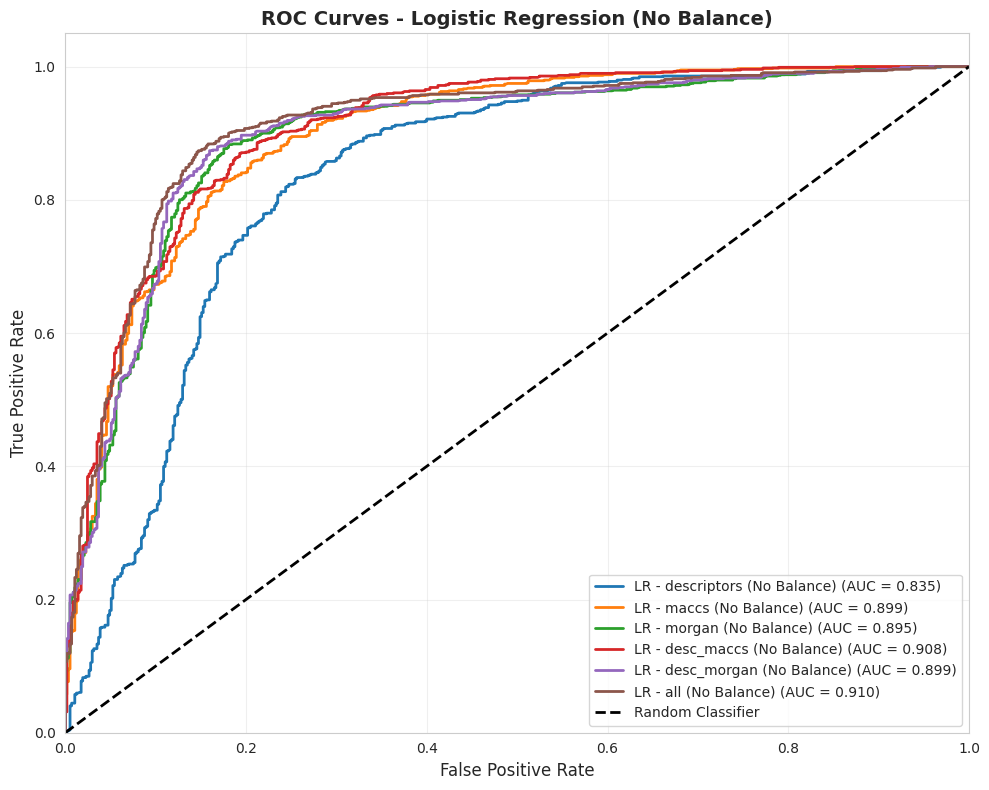

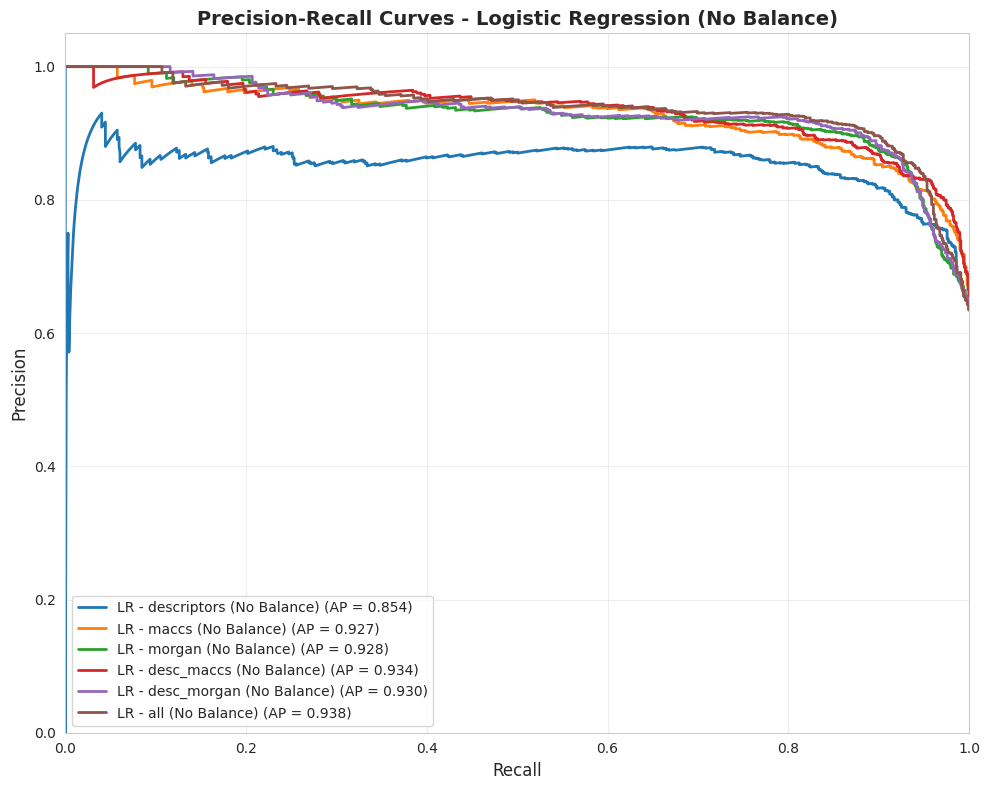

In [11]:
# Plot ROC and PR curves for LR without balance
plot_roc_curve(lr_results_no_balance, title="ROC Curves - Logistic Regression (No Balance)")
plot_precision_recall_curve(lr_results_no_balance, title="Precision-Recall Curves - Logistic Regression (No Balance)")

### 6.2 With Class Imbalance Handling (SMOTE)

Using SMOTE to balance the training data

In [12]:
# Logistic Regression with SMOTE
lr_results_smote = []

for feature_name in ['descriptors', 'maccs', 'morgan', 'desc_maccs', 'all']:
    split = splits[feature_name]
    
    # Apply SMOTE to training data
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_balanced, y_train_balanced = smote.fit_resample(split['X_train'], split['y_train'])
    
    print(f"\n{feature_name}: Original train size: {len(split['y_train'])}, Balanced: {len(y_train_balanced)}")
    print(f"Class distribution after SMOTE: {np.bincount(y_train_balanced)}")
    
    lr_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
    lr_model.fit(X_train_balanced, y_train_balanced)
    
    y_pred = lr_model.predict(split['X_test'])
    y_pred_proba = lr_model.predict_proba(split['X_test'])[:, 1]
    
    results = evaluate_model(
        lr_model,
        X_train_balanced, split['X_test'],
        y_train_balanced, split['y_test'],
        model_name=f"LR - {feature_name} (SMOTE)"
    )
    
    lr_results_smote.append(results)
    all_results.append(results)


descriptors: Original train size: 6244, Balanced: 7930
Class distribution after SMOTE: [3965 3965]
  LR - descriptors (SMOTE)

Overall Metrics:
  Accuracy: 0.7995

Precision:
  BBB- (Class 0): 0.7189
  BBB+ (Class 1): 0.8480
  Macro Average: 0.7835
  Weighted Average: 0.8009

Recall:
  BBB- (Class 0): 0.7404
  BBB+ (Class 1): 0.8335
  Macro Average: 0.7869
  Weighted Average: 0.7995

F1-Score:
  BBB- (Class 0): 0.7295
  BBB+ (Class 1): 0.8407
  Macro Average: 0.7851
  Weighted Average: 0.8001

ROC AUC Score: 0.8365
Average Precision Score: 0.8595

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.72      0.74      0.73       570
        BBB+       0.85      0.83      0.84       991

    accuracy                           0.80      1561
   macro avg       0.78      0.79      0.79      1561
weighted avg       0.80      0.80      0.80      1561


maccs: Original train size: 6244, Balanced: 7930
Class distribution after SMOTE: [3965 3965]
 

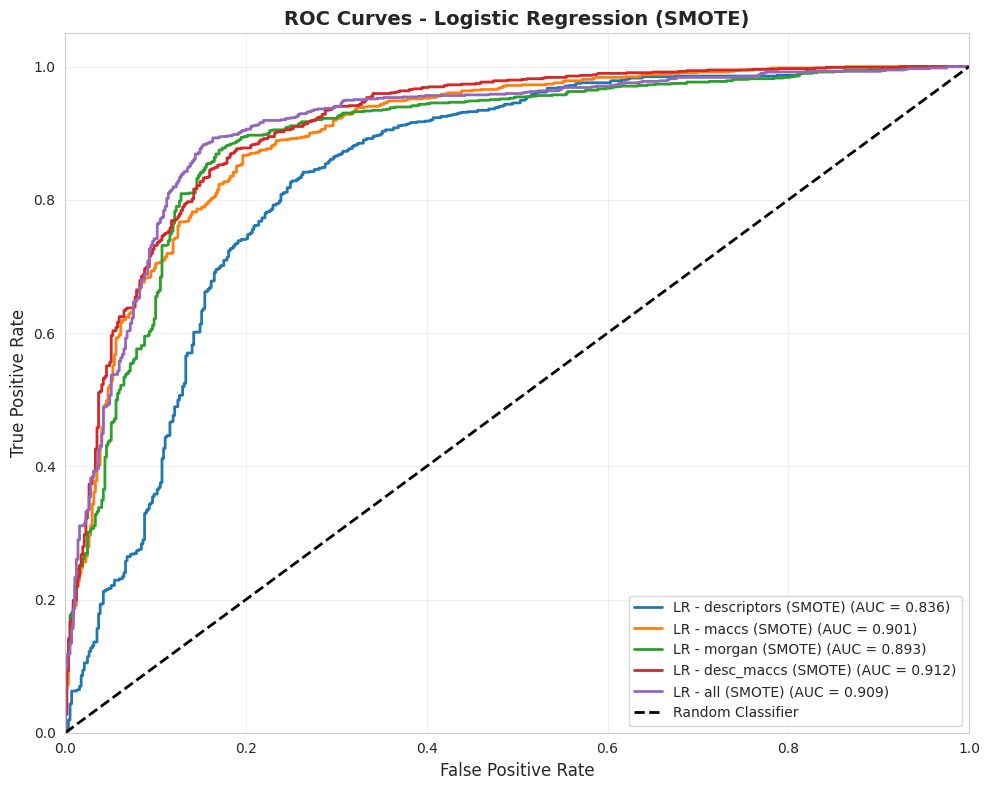

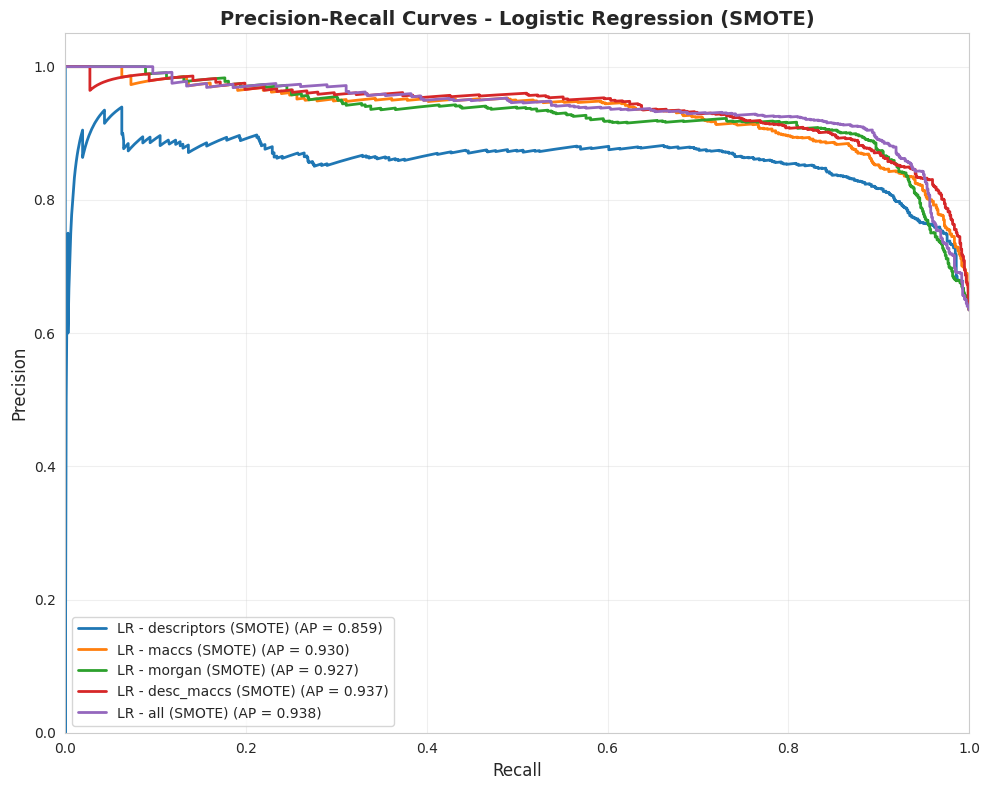

In [13]:
# Plot ROC and PR curves for LR with SMOTE
plot_roc_curve(lr_results_smote, title="ROC Curves - Logistic Regression (SMOTE)")
plot_precision_recall_curve(lr_results_smote, title="Precision-Recall Curves - Logistic Regression (SMOTE)")

### 6.4 Logistic Regression with Class Weighting

Use class_weight='balanced' (and explicit computed class weights) to handle imbalance without resampling. We'll train and evaluate Logistic Regression across the same feature sets and compare ROC / PR curves.


descriptors class weights: {0: np.float64(1.3698990785432208), 1: np.float64(0.7873896595208071)}
  LR - descriptors (ClassWeight)

Overall Metrics:
  Accuracy: 0.7976

Precision:
  BBB- (Class 0): 0.7153
  BBB+ (Class 1): 0.8476
  Macro Average: 0.7814
  Weighted Average: 0.7993

Recall:
  BBB- (Class 0): 0.7404
  BBB+ (Class 1): 0.8305
  Macro Average: 0.7854
  Weighted Average: 0.7976

F1-Score:
  BBB- (Class 0): 0.7276
  BBB+ (Class 1): 0.8389
  Macro Average: 0.7833
  Weighted Average: 0.7983

ROC AUC Score: 0.8361
Average Precision Score: 0.8578

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.72      0.74      0.73       570
        BBB+       0.85      0.83      0.84       991

    accuracy                           0.80      1561
   macro avg       0.78      0.79      0.78      1561
weighted avg       0.80      0.80      0.80      1561


maccs class weights: {0: np.float64(1.3698990785432208), 1: np.float64(0.7873896595208071

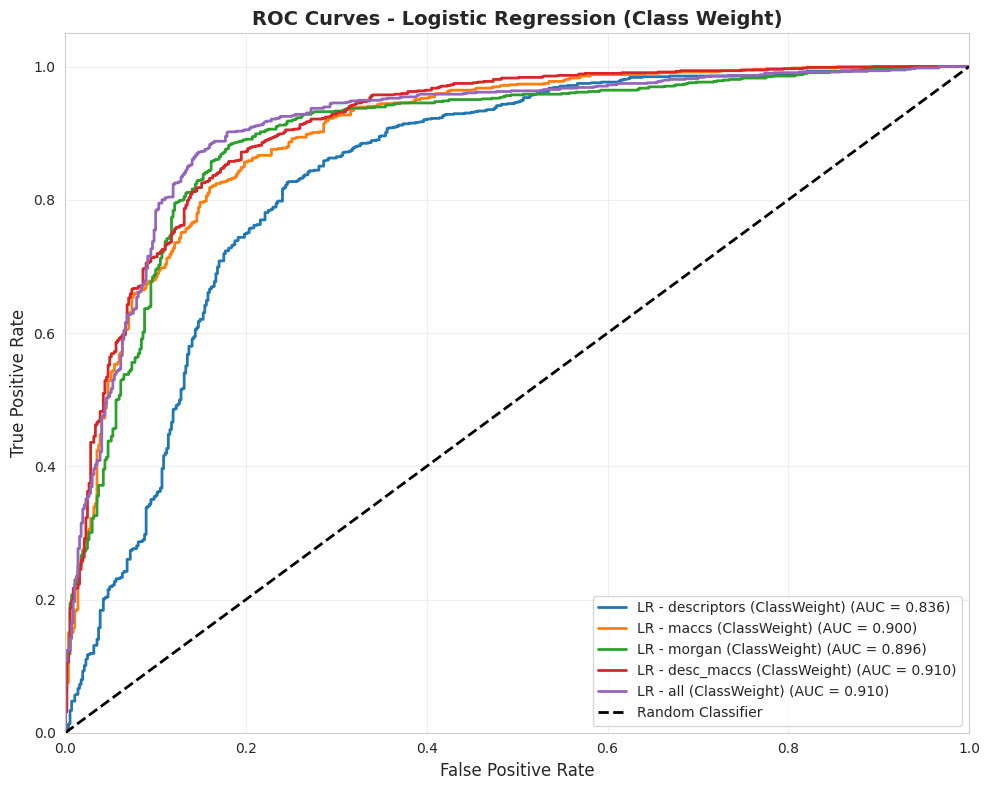

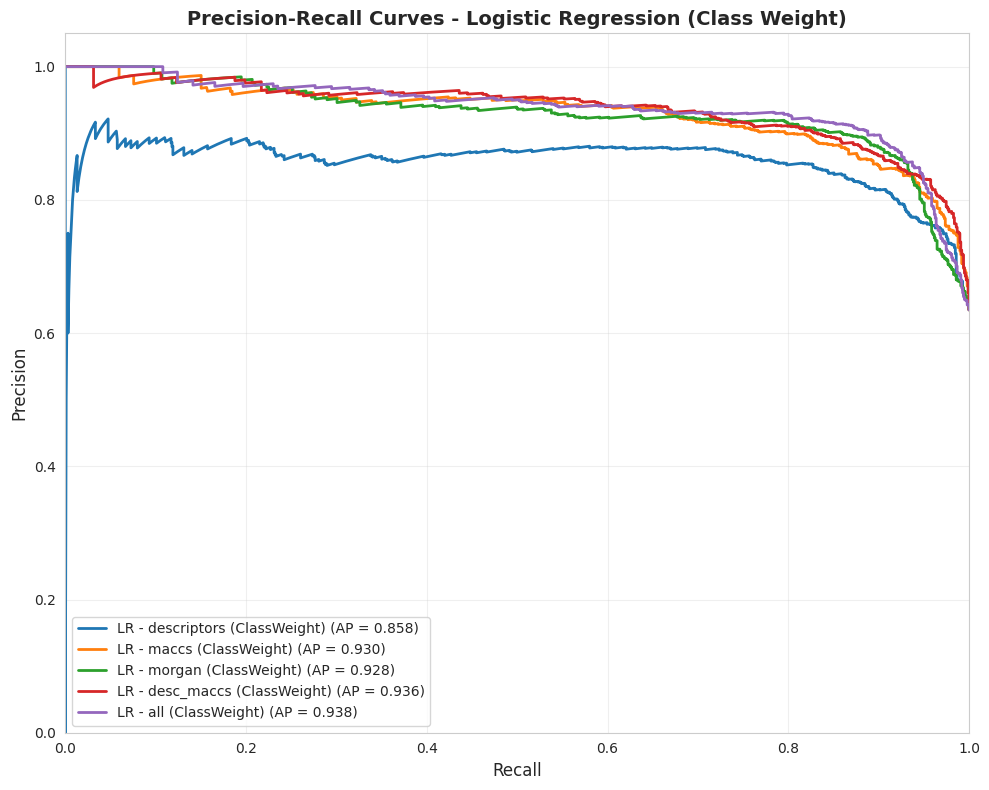

In [14]:
# Logistic Regression with class weighting
from sklearn.utils.class_weight import compute_class_weight

lr_results_class_weight = []

for feature_name in ['descriptors', 'maccs', 'morgan', 'desc_maccs', 'all']:
    split = splits[feature_name]
    
    # Compute class weights from training data
    classes = np.unique(split['y_train'])
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=split['y_train'])
    cw = {int(c): w for c, w in zip(classes, class_weights)}
    print(f"\n{feature_name} class weights: {cw}")
    
    # Train Logistic Regression with class_weight
    lr_model_cw = LogisticRegression(max_iter=1000, class_weight=cw, random_state=RANDOM_STATE)
    
    results = evaluate_model(
        lr_model_cw,
        split['X_train'], split['X_test'],
        split['y_train'], split['y_test'],
        model_name=f"LR - {feature_name} (ClassWeight)"
    )
    
    lr_results_class_weight.append(results)
    all_results.append(results)

# Plot ROC and PR curves for class-weighted LR
plot_roc_curve(lr_results_class_weight, title="ROC Curves - Logistic Regression (Class Weight)")
plot_precision_recall_curve(lr_results_class_weight, title="Precision-Recall Curves - Logistic Regression (Class Weight)")

### 6.3 Logistic Regression with PCA

Using PCA to reduce dimensionality and identify most important features

In [15]:
# Apply PCA to find optimal number of components (explaining 95% variance)
lr_results_pca = []

for feature_name in ['descriptors', 'maccs', 'morgan', 'all']:
    split = splits[feature_name]
    
    # Apply PCA with 95% variance explained
    pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
    X_train_pca = pca.fit_transform(split['X_train'])
    X_test_pca = pca.transform(split['X_test'])
    
    print(f"\n{feature_name}:")
    print(f"  Original dimensions: {split['X_train'].shape[1]}")
    print(f"  PCA components (95% variance): {X_train_pca.shape[1]}")
    print(f"  Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")
    
    # Train Logistic Regression on PCA features
    lr_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
    
    results = evaluate_model(
        lr_model,
        X_train_pca, X_test_pca,
        split['y_train'], split['y_test'],
        model_name=f"LR - {feature_name} (PCA 95%)"
    )
    
    lr_results_pca.append(results)
    all_results.append(results)


descriptors:
  Original dimensions: 12
  PCA components (95% variance): 6
  Explained variance ratio: 0.9609
  LR - descriptors (PCA 95%)

Overall Metrics:
  Accuracy: 0.7976

Precision:
  BBB- (Class 0): 0.8098
  BBB+ (Class 1): 0.7932
  Macro Average: 0.8015
  Weighted Average: 0.7993

Recall:
  BBB- (Class 0): 0.5825
  BBB+ (Class 1): 0.9213
  Macro Average: 0.7519
  Weighted Average: 0.7976

F1-Score:
  BBB- (Class 0): 0.6776
  BBB+ (Class 1): 0.8525
  Macro Average: 0.7650
  Weighted Average: 0.7886

ROC AUC Score: 0.8226
Average Precision Score: 0.8227

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.81      0.58      0.68       570
        BBB+       0.79      0.92      0.85       991

    accuracy                           0.80      1561
   macro avg       0.80      0.75      0.77      1561
weighted avg       0.80      0.80      0.79      1561


maccs:
  Original dimensions: 167
  PCA components (95% variance): 89
  Explained 

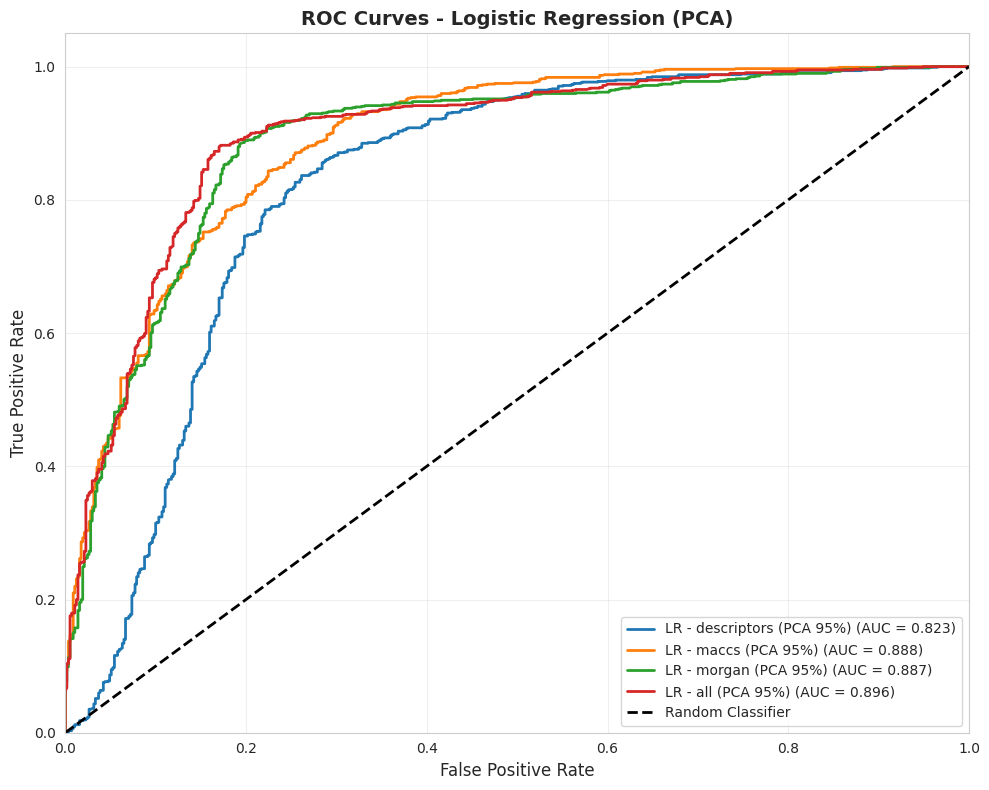

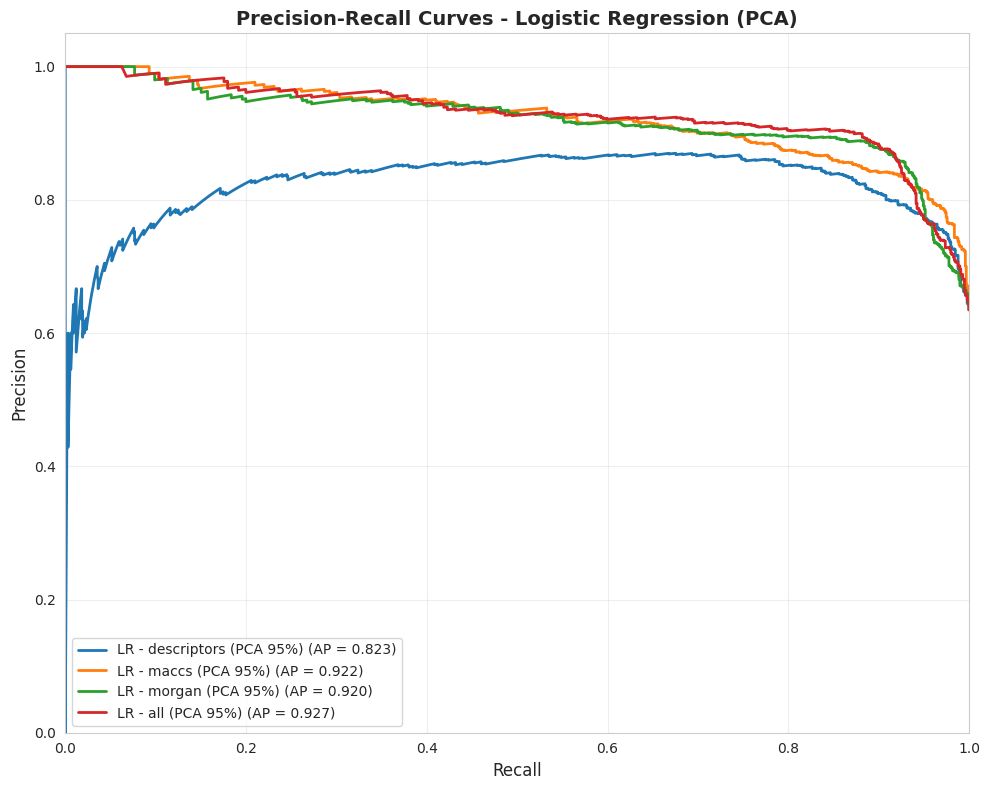

In [16]:
# Plot ROC and PR curves for LR with PCA
plot_roc_curve(lr_results_pca, title="ROC Curves - Logistic Regression (PCA)")
plot_precision_recall_curve(lr_results_pca, title="Precision-Recall Curves - Logistic Regression (PCA)")

## 7. Random Forest Experiments

### 7.1 Random Forest with Default Parameters (No Balance)

In [17]:
# Random Forest without class imbalance handling
rf_results_no_balance = []

for feature_name in ['descriptors', 'maccs', 'morgan', 'desc_maccs', 'all']:
    split = splits[feature_name]
    
    # Create and train model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
    
    results = evaluate_model(
        rf_model,
        split['X_train'], split['X_test'],
        split['y_train'], split['y_test'],
        model_name=f"RF - {feature_name} (No Balance)"
    )
    
    rf_results_no_balance.append(results)
    all_results.append(results)

  RF - descriptors (No Balance)

Overall Metrics:
  Accuracy: 0.8757

Precision:
  BBB- (Class 0): 0.8615
  BBB+ (Class 1): 0.8828
  Macro Average: 0.8722
  Weighted Average: 0.8750

Recall:
  BBB- (Class 0): 0.7860
  BBB+ (Class 1): 0.9273
  Macro Average: 0.8567
  Weighted Average: 0.8757

F1-Score:
  BBB- (Class 0): 0.8220
  BBB+ (Class 1): 0.9045
  Macro Average: 0.8633
  Weighted Average: 0.8744

ROC AUC Score: 0.9512
Average Precision Score: 0.9693

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.86      0.79      0.82       570
        BBB+       0.88      0.93      0.90       991

    accuracy                           0.88      1561
   macro avg       0.87      0.86      0.86      1561
weighted avg       0.88      0.88      0.87      1561

  RF - maccs (No Balance)

Overall Metrics:
  Accuracy: 0.8943

Precision:
  BBB- (Class 0): 0.8872
  BBB+ (Class 1): 0.8979
  Macro Average: 0.8925
  Weighted Average: 0.8940

Recall:
  BBB

### 7.2 Random Forest with SMOTE

In [18]:
# Random Forest with SMOTE
rf_results_smote = []

for feature_name in ['descriptors', 'maccs', 'morgan', 'desc_maccs', 'all']:
    split = splits[feature_name]
    
    # Apply SMOTE to training data
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_balanced, y_train_balanced = smote.fit_resample(split['X_train'], split['y_train'])
    
    # Create and train model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
    rf_model.fit(X_train_balanced, y_train_balanced)
    
    results = evaluate_model(
        rf_model,
        X_train_balanced, split['X_test'],
        y_train_balanced, split['y_test'],
        model_name=f"RF - {feature_name} (SMOTE)"
    )
    
    rf_results_smote.append(results)
    all_results.append(results)

  RF - descriptors (SMOTE)

Overall Metrics:
  Accuracy: 0.8751

Precision:
  BBB- (Class 0): 0.8391
  BBB+ (Class 1): 0.8948
  Macro Average: 0.8670
  Weighted Average: 0.8745

Recall:
  BBB- (Class 0): 0.8140
  BBB+ (Class 1): 0.9102
  Macro Average: 0.8621
  Weighted Average: 0.8751

F1-Score:
  BBB- (Class 0): 0.8264
  BBB+ (Class 1): 0.9025
  Macro Average: 0.8644
  Weighted Average: 0.8747

ROC AUC Score: 0.9513
Average Precision Score: 0.9681

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.84      0.81      0.83       570
        BBB+       0.89      0.91      0.90       991

    accuracy                           0.88      1561
   macro avg       0.87      0.86      0.86      1561
weighted avg       0.87      0.88      0.87      1561

  RF - maccs (SMOTE)

Overall Metrics:
  Accuracy: 0.9013

Precision:
  BBB- (Class 0): 0.8910
  BBB+ (Class 1): 0.9067
  Macro Average: 0.8988
  Weighted Average: 0.9010

Recall:
  BBB- (Class 0

### 7.3 Random Forest with PCA

In [19]:
# Random Forest with PCA
rf_results_pca = []

for feature_name in ['descriptors', 'maccs', 'morgan', 'all']:
    split = splits[feature_name]
    
    # Apply PCA
    pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
    X_train_pca = pca.fit_transform(split['X_train'])
    X_test_pca = pca.transform(split['X_test'])
    
    print(f"\n{feature_name}: PCA components = {X_train_pca.shape[1]}")
    
    # Train Random Forest on PCA features
    rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
    
    results = evaluate_model(
        rf_model,
        X_train_pca, X_test_pca,
        split['y_train'], split['y_test'],
        model_name=f"RF - {feature_name} (PCA 95%)"
    )
    
    rf_results_pca.append(results)
    all_results.append(results)


descriptors: PCA components = 6
  RF - descriptors (PCA 95%)

Overall Metrics:
  Accuracy: 0.8719

Precision:
  BBB- (Class 0): 0.8517
  BBB+ (Class 1): 0.8821
  Macro Average: 0.8669
  Weighted Average: 0.8710

Recall:
  BBB- (Class 0): 0.7860
  BBB+ (Class 1): 0.9213
  Macro Average: 0.8536
  Weighted Average: 0.8719

F1-Score:
  BBB- (Class 0): 0.8175
  BBB+ (Class 1): 0.9013
  Macro Average: 0.8594
  Weighted Average: 0.8707

ROC AUC Score: 0.9444
Average Precision Score: 0.9625

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.85      0.79      0.82       570
        BBB+       0.88      0.92      0.90       991

    accuracy                           0.87      1561
   macro avg       0.87      0.85      0.86      1561
weighted avg       0.87      0.87      0.87      1561


maccs: PCA components = 89
  RF - maccs (PCA 95%)

Overall Metrics:
  Accuracy: 0.8917

Precision:
  BBB- (Class 0): 0.9067
  BBB+ (Class 1): 0.8848
  Macro Av

### 7.4 Random Forest with Hyperparameter Tuning (RandomizedSearchCV)

Tuning on the best performing feature set

In [ ]:
# Hyperparameter tuning for Random Forest
# We'll tune on the 'all' features as it is performing best.

split = splits['all']

# Apply SMOTE for balanced training
smote = SMOTE(random_state=RANDOM_STATE)
X_train_balanced, y_train_balanced = smote.fit_resample(split['X_train'], split['y_train'])

# Define parameter grid
param_distributions = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Create RandomizedSearchCV
rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings sampled
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

print("Performing RandomizedSearchCV for Random Forest...")

rf_random.fit(X_train_balanced, y_train_balanced)

print(f"\nBest parameters found:")
print(rf_random.best_params_)
print(f"\nBest cross-validation ROC AUC score: {rf_random.best_score_:.4f}")

# Evaluate best model
best_rf = rf_random.best_estimator_
y_pred = best_rf.predict(split['X_test'])
y_pred_proba = best_rf.predict_proba(split['X_test'])[:, 1]

results_tuned = evaluate_model(
    best_rf,
    X_train_balanced, split['X_test'],
    y_train_balanced, split['y_test'],
    model_name="RF - all (Tuned + SMOTE)",
    y_pred_proba=y_pred_proba
)

all_results.append(results_tuned)

Performing RandomizedSearchCV for Random Forest...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [ ]:
# Plot comparison of RF models
rf_comparison = rf_results_no_balance + rf_results_smote + [results_tuned]
plot_roc_curve(rf_comparison[:5], title="ROC Curves - Random Forest Comparison")
plot_precision_recall_curve(rf_comparison[:5], title="Precision-Recall Curves - Random Forest Comparison")

## 8. XGBoost Experiments

### 8.1 XGBoost with Different Feature Sets

In [ ]:
# XGBoost without class imbalance handling
xgb_results_no_balance = []

for feature_name in ['descriptors', 'maccs', 'morgan', 'desc_maccs', 'all']:
    split = splits[feature_name]
    
    # Create and train model
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1
    )
    
    results = evaluate_model(
        xgb_model,
        split['X_train'], split['X_test'],
        split['y_train'], split['y_test'],
        model_name=f"XGB - {feature_name} (No Balance)"
    )
    
    xgb_results_no_balance.append(results)
    all_results.append(results)

### 8.2 XGBoost with SMOTE

In [ ]:
# XGBoost with SMOTE
xgb_results_smote = []

for feature_name in ['descriptors', 'maccs', 'morgan', 'desc_maccs', 'all']:
    split = splits[feature_name]
    
    # Apply SMOTE to training data
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_balanced, y_train_balanced = smote.fit_resample(split['X_train'], split['y_train'])
    
    # Create and train model
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1
    )
    xgb_model.fit(X_train_balanced, y_train_balanced)
    
    results = evaluate_model(
        xgb_model,
        X_train_balanced, split['X_test'],
        y_train_balanced, split['y_test'],
        model_name=f"XGB - {feature_name} (SMOTE)"
    )
    
    xgb_results_smote.append(results)
    all_results.append(results)

In [ ]:
# Plot XGBoost comparison
xgb_comparison = xgb_results_no_balance + xgb_results_smote
plot_roc_curve(xgb_comparison[:6], title="ROC Curves - XGBoost Comparison")
plot_precision_recall_curve(xgb_comparison[:6], title="Precision-Recall Curves - XGBoost Comparison")

## 9. Ensemble Methods

Combining multiple models for improved performance

### 9.1 Voting Classifier (Soft Voting)

In [ ]:
# Voting Classifier with best models from each type
# Using 'all' features with SMOTE

split = splits['all']
smote = SMOTE(random_state=RANDOM_STATE)
X_train_balanced, y_train_balanced = smote.fit_resample(split['X_train'], split['y_train'])

# Define base estimators
lr = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
xgb_clf = xgb.XGBClassifier(n_estimators=100, random_state=RANDOM_STATE, 
                            use_label_encoder=False, eval_metric='logloss', n_jobs=-1)

# Create voting classifier
voting_clf = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf), ('xgb', xgb_clf)],
    voting='soft'
)

print("Training Voting Classifier...")
results_voting = evaluate_model(
    voting_clf,
    X_train_balanced, split['X_test'],
    y_train_balanced, split['y_test'],
    model_name="Voting Ensemble (LR+RF+XGB, SMOTE)"
)

all_results.append(results_voting)

### 9.2 Stacking Classifier

In [ ]:
# Stacking Classifier
# Base models: LR, RF, XGB
# Meta-model: Logistic Regression

base_estimators = [
    ('lr', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)),
    ('xgb', xgb.XGBClassifier(n_estimators=100, random_state=RANDOM_STATE, 
                              use_label_encoder=False, eval_metric='logloss', n_jobs=-1))
]

stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)

print("Training Stacking Classifier...")
results_stacking = evaluate_model(
    stacking_clf,
    X_train_balanced, split['X_test'],
    y_train_balanced, split['y_test'],
    model_name="Stacking Ensemble (LR+RF+XGB, SMOTE)"
)

all_results.append(results_stacking)

## 10. Final Comparison

### 10.1 Compare All Models

In [ ]:
# Create comparison dataframe
comparison_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'Accuracy': r['accuracy'],
        'Precision (BBB-)': r['precision_class_0'],
        'Precision (BBB+)': r['precision_class_1'],
        'Recall (BBB-)': r['recall_class_0'],
        'Recall (BBB+)': r['recall_class_1'],
        'F1 (BBB-)': r['f1_class_0'],
        'F1 (BBB+)': r['f1_class_1'],
        'F1 Macro': r['f1_macro'],
        'ROC AUC': r['roc_auc'] if r['roc_auc'] else 0
    }
    for r in all_results
])

# Sort by ROC AUC
comparison_df = comparison_df.sort_values('ROC AUC', ascending=False)

print("="*120)
print("FINAL COMPARISON OF ALL MODELS")
print("="*120)
print(comparison_df.to_string(index=False))

# Save to CSV
comparison_df.to_csv('../figures/model_comparison.csv', index=False)
print("\n✓ Results saved to figures/model_comparison.csv")

### 10.2 Visualize Top Performing Models

In [ ]:
# Plot ROC and PR curves for top 10 models
top_10_models = [r for r in sorted(all_results, key=lambda x: x['roc_auc'] if x['roc_auc'] else 0, reverse=True)[:10]]

print(f"Top 10 models by ROC AUC:")
for i, r in enumerate(top_10_models, 1):
    print(f"{i}. {r['model_name']}: {r['roc_auc']:.4f}")

plot_roc_curve(top_10_models, title="ROC Curves - Top 10 Models")
plot_precision_recall_curve(top_10_models, title="Precision-Recall Curves - Top 10 Models")

In [ ]:
# Bar chart for top models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC AUC comparison
top_models_df = comparison_df.head(15)
axes[0].barh(range(len(top_models_df)), top_models_df['ROC AUC'], color='steelblue')
axes[0].set_yticks(range(len(top_models_df)))
axes[0].set_yticklabels(top_models_df['Model'], fontsize=8)
axes[0].set_xlabel('ROC AUC Score', fontsize=12)
axes[0].set_title('Top 15 Models by ROC AUC', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# F1 Macro comparison
axes[1].barh(range(len(top_models_df)), top_models_df['F1 Macro'], color='coral')
axes[1].set_yticks(range(len(top_models_df)))
axes[1].set_yticklabels(top_models_df['Model'], fontsize=8)
axes[1].set_xlabel('F1 Macro Score', fontsize=12)
axes[1].set_title('Top 15 Models by F1 Macro', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/top_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved to figures/top_models_comparison.png")

### 10.3 Class Imbalance Treatment Comparison

Compare performance with and without class imbalance handling

In [ ]:
# Compare models with and without SMOTE for the same feature set
print("="*80)
print("IMPACT OF CLASS IMBALANCE HANDLING (SMOTE)")
print("="*80)

# Extract results with 'all' features for fair comparison
lr_no_balance = [r for r in lr_results_no_balance if 'all' in r['model_name']][0]
lr_smote = [r for r in lr_results_smote if 'all' in r['model_name']][0]
rf_no_balance = [r for r in rf_results_no_balance if 'all' in r['model_name']][0]
rf_smote = [r for r in rf_results_smote if 'all' in r['model_name']][0]
xgb_no_balance = [r for r in xgb_results_no_balance if 'all' in r['model_name']][0]
xgb_smote = [r for r in xgb_results_smote if 'all' in r['model_name']][0]

imbalance_comparison = pd.DataFrame([
    {
        'Model': 'Logistic Regression',
        'No Balance - Accuracy': lr_no_balance['accuracy'],
        'SMOTE - Accuracy': lr_smote['accuracy'],
        'No Balance - ROC AUC': lr_no_balance['roc_auc'],
        'SMOTE - ROC AUC': lr_smote['roc_auc'],
        'No Balance - F1 (BBB+)': lr_no_balance['f1_class_1'],
        'SMOTE - F1 (BBB+)': lr_smote['f1_class_1']
    },
    {
        'Model': 'Random Forest',
        'No Balance - Accuracy': rf_no_balance['accuracy'],
        'SMOTE - Accuracy': rf_smote['accuracy'],
        'No Balance - ROC AUC': rf_no_balance['roc_auc'],
        'SMOTE - ROC AUC': rf_smote['roc_auc'],
        'No Balance - F1 (BBB+)': rf_no_balance['f1_class_1'],
        'SMOTE - F1 (BBB+)': rf_smote['f1_class_1']
    },
    {
        'Model': 'XGBoost',
        'No Balance - Accuracy': xgb_no_balance['accuracy'],
        'SMOTE - Accuracy': xgb_smote['accuracy'],
        'No Balance - ROC AUC': xgb_no_balance['roc_auc'],
        'SMOTE - ROC AUC': xgb_smote['roc_auc'],
        'No Balance - F1 (BBB+)': xgb_no_balance['f1_class_1'],
        'SMOTE - F1 (BBB+)': xgb_smote['f1_class_1']
    }
])

print(imbalance_comparison.to_string(index=False))

# Visualize the impact
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['Accuracy', 'ROC AUC', 'F1 (BBB+)']
for idx, metric in enumerate(metrics):
    no_balance_col = f'No Balance - {metric}'
    smote_col = f'SMOTE - {metric}'
    
    x = np.arange(len(imbalance_comparison))
    width = 0.35
    
    axes[idx].bar(x - width/2, imbalance_comparison[no_balance_col], width, 
                  label='No Balance', color='lightcoral')
    axes[idx].bar(x + width/2, imbalance_comparison[smote_col], width, 
                  label='SMOTE', color='lightgreen')
    
    axes[idx].set_xlabel('Model', fontsize=12)
    axes[idx].set_ylabel(metric, fontsize=12)
    axes[idx].set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(imbalance_comparison['Model'], rotation=15, ha='right')
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/imbalance_treatment_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved to figures/imbalance_treatment_comparison.png")

## 11. Summary and Conclusions

Key findings from the experiments:

In [ ]:
# Print summary
best_model = comparison_df.iloc[0]

print("="*80)
print("EXPERIMENT SUMMARY")
print("="*80)
print(f"\n📊 Total models evaluated: {len(all_results)}")
print(f"\n🏆 Best performing model: {best_model['Model']}")
print(f"   - ROC AUC: {best_model['ROC AUC']:.4f}")
print(f"   - Accuracy: {best_model['Accuracy']:.4f}")
print(f"   - F1 Macro: {best_model['F1 Macro']:.4f}")
print(f"   - Precision (BBB+): {best_model['Precision (BBB+)']:.4f}")
print(f"   - Recall (BBB+): {best_model['Recall (BBB+)']:.4f}")

print(f"\n📈 Key Findings:")
print(f"   1. Feature Representations:")
print(f"      - Combined features (descriptors + fingerprints) generally perform best")
print(f"      - Fingerprints (MACCS, Morgan) provide strong predictive power")

# Count SMOTE vs no balance in top 10
top_10_smote_count = sum(1 for r in top_10_models if 'SMOTE' in r['model_name'])
top_10_no_balance_count = sum(1 for r in top_10_models if 'No Balance' in r['model_name'])

print(f"\n   2. Class Imbalance Handling:")
print(f"      - Top 10 models with SMOTE: {top_10_smote_count}")
print(f"      - Top 10 models without balance: {top_10_no_balance_count}")
print(f"      - SMOTE generally improves minority class (BBB+) detection")

# Count model types in top 10
lr_count = sum(1 for r in top_10_models if r['model_name'].startswith('LR'))
rf_count = sum(1 for r in top_10_models if r['model_name'].startswith('RF'))
xgb_count = sum(1 for r in top_10_models if r['model_name'].startswith('XGB'))
ensemble_count = sum(1 for r in top_10_models if 'Ensemble' in r['model_name'])

print(f"\n   3. Model Types (in top 10):")
print(f"      - Logistic Regression: {lr_count}")
print(f"      - Random Forest: {rf_count}")
print(f"      - XGBoost: {xgb_count}")
print(f"      - Ensemble: {ensemble_count}")

print(f"\n   4. Dimensionality Reduction (PCA):")
pca_in_top_10 = sum(1 for r in top_10_models if 'PCA' in r['model_name'])
print(f"      - PCA models in top 10: {pca_in_top_10}")
print(f"      - PCA reduces features while maintaining good performance")

print(f"\n📁 All results saved to:")
print(f"   - figures/model_comparison.csv")
print(f"   - figures/top_models_comparison.png")
print(f"   - figures/imbalance_treatment_comparison.png")

print(f"\n" + "="*80)
print(f"EXPERIMENT COMPLETE!")
print("="*80)